In [1]:
import numpy as np
import scipy as sc
import numpy.linalg as npl
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#%load_ext line_profiler

# Funcs

## get Lennard Jones forces

In [4]:
def get_separations(position,positions):
    
    r = np.subtract(position,positions).reshape((-1,3))
    
    distances2 = np.power(r,2).sum(axis=1)
    norms = np.sqrt(distances2).reshape((-1,1))
    direction_vectors = r#np.divide(r,norms)
    return distances2,direction_vectors
    
def get_forces_LJ(positions,sigma,epsilon):
    
    ll = list(set(range(Natom)).difference([iatom]))
    distances2,direction_vectors = get_separations(positions[iatom],positions[ll])

    c6 = np.power(np.divide(sigma**2, distances2),3)
    c12 = np.power(c6,2)

    #energy += 0.5 * np.sum(np.multiply(4 * epsilon , np.subtract(c12,c6)))

    forces[iatom] += np.multiply(np.multiply(4 * epsilon ,np.subtract(np.multiply(c12, 12), np.multiply(c6, 6))).reshape((Natom-1,1)), 
                                     direction_vectors).sum(axis=0)
        
    
    return forces

def get_forces_LJ2(positions,sigma,epsilon):
    Natom,_ = positions.shape
    forces = np.zeros((Natom,3))
    
    ll = np.arange(Natom)
    ll = [[ll[i - j] for i in range(1,Natom)] for j in range(Natom, 0, -1)]
    
    pps = np.asarray([positions[ll[it]] for it in range(Natom)],dtype=np.float64)
    
    r = np.subtract(positions.reshape((Natom,1,3)),pps)
    distances2 = np.power(r,2).sum(axis=2)
    norms = np.sqrt(distances2).reshape((Natom,Natom-1,1))
    
    c6 = np.power(np.divide(sigma**2, distances2),3)
    c12 = np.power(c6,2)
    
    forces = np.multiply(np.multiply(4 * epsilon ,np.subtract(np.multiply(c12, 12), np.multiply(c6, 6))).reshape((Natom,Natom-1,1)), 
                                     np.divide(r,norms)).sum(axis=1)
    return forces

#def get_forces_LJ3(positions,sigma,epsilon):
    
n = 10
#f1 = get_forces_LJ(np.random.rand(n,3),sigma=1,epsilon=1)
f2 = get_forces_LJ2(np.random.rand(n,3),sigma=1,epsilon=1)
#np.allclose(f1,f2)

In [5]:
def get_numerical_force(pot_func,r,*args):
    from numpy.linalg import norm
    e_x,e_y,e_z = np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])
    h = 1e-3
    F_x = - ( pot_func(norm(r+e_x*h),*args) - pot_func(norm(r-e_x*h),*args) )  / (2*h)
    F_y = - ( pot_func(norm(r+e_y*h),*args) - pot_func(norm(r-e_y*h),*args) )  / (2*h)
    F_z = - ( pot_func(norm(r+e_z*h),*args) - pot_func(norm(r-e_z*h),*args) )  / (2*h)
    return np.array([F_x,F_y,F_z])

In [6]:
def calcule_r_et_d(positions):
    Nparticule,_ = positions.shape
    # matrice des distances
    distances2 = np.zeros((Nparticule,Nparticule-1))
    # matrice des vecteurs de direction
    sepVec = np.zeros((Nparticule,Nparticule-1,3))
    # TODO
    dd_diag = np.zeros((Nparticule-1))
    sepVec_diag = np.zeros((Nparticule-1,3))
    for ii in range(Nparticule-1):
        # calcule les vecteurs d'orientation: pour chaque position prendre la difference avec les autres positions
        rr = positions[ii] - positions[ii+1:]
        # calcule la norme des vecteur d'orientation
        dd = np.power(rr,2).sum(axis=1)
        dd_diag[ii] = np.sqrt(dd[0])
        sepVec_diag[ii] = rr[0] / dd_diag[ii]
        # distances2[ii,ii+1:] = distances2[ii+1:,ii] = dd
        distances2[ii,ii:] = distances2[ii+1:,ii] = dd
        #distances2[ii+1:,ii] = dd
        # normalise les vecteurs d'orientation
        sepVec[ii,ii:,:] = rr 
        sepVec[ii+1:,ii,:] = - sepVec[ii,ii:,:]
    return distances2,sepVec,dd_diag,sepVec_diag

$\mathbf{F}_{LJ}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{LJ}\left(d\right) = \mathbf{\hat{r}}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right] $

In [7]:
def get_forces_LJ(distances2,sepVec,r_m,epsilon,forces):
    Natom,_ = positions.shape
    #forces = np.zeros((Natom,3))
    r_m2 = r_m**2
    epsi = 12*epsilon
    pot = 0
    for iatom in range(Natom):
        c6 = np.power(np.divide(r_m2,distances2[iatom]),3)
        c12 = np.power(c6,2)
        fac = np.multiply(np.divide(epsi,distances2[iatom]),np.subtract(c12,c6)).reshape((1,-1,1))
        forces[iatom] += np.sum(np.multiply(sepVec[iatom],fac),axis=1).flatten()
        pot += np.sum(epsilon*np.subtract(c12,2*c6))
    return pot

$\mathbf{F}_{Har}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{Har}\left(d\right) =  - 2 k \, (d - r_m)  \mathbf{\hat{r}} $


In [8]:
def get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces):
    
    force_resort = np.multiply( -2*k_spring*(dd_diag-r_m).reshape((-1,1)),sepVec_diag)
    forces[:-1] += force_resort
    forces[1:] -= force_resort
    pot = np.sum( k_spring*(dd_diag-r_m)**2 )
    return pot

In [9]:
def Potentiel_Harmonique(d,r_m,k):
    ''' '''
    return k*( d - r_m)**2
def Potentiel_LennardJones(d,r_m,epsilon):
    ''' '''
    return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)

In [10]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1]]),0.8,1.,1.
#positions,r_m,epsilon,k_spring = np.array([[0,0,0],[0.9,1.3,0.99]]),1.2,1.,1

In [11]:
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

In [568]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1]]),0.8,1.,1.
rot = rotation_matrix([0,1,1],np.pi*0.)
positions = np.dot(positions,rot)
np.linalg.norm(positions[1]-positions[0])

1.0

In [569]:
Nparticule = len(positions)
distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)

### check lj

In [551]:
r = positions[2]-positions[0]
F_num = get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
r = positions[2]-positions[1]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
r = positions[2]-positions[3]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
F_num

IndexError: index 3 is out of bounds for axis 0 with size 3

In [535]:
forces = np.zeros((len(positions),3))
get_forces_LJ(distances2,sepVec,r_m,epsilon,forces)
forces

array([[-1.54538119, -1.95447614, -0.36661814],
       [ 0.        ,  2.32109428,  2.32109428],
       [ 1.54538119, -0.36661814, -1.95447614]])

### check harm

In [570]:
r = (positions[1]-positions[0])
F_num = get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
F_num

array([-0. ,  0.4, -0. ])

In [571]:
r = (positions[0]-positions[1])
F_num = get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
r = positions[1]-positions[2]
F_num -= get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
F_num

array([ 0. , -0.4, -0.4])

In [572]:
aa = np.zeros((Nparticule-1))
bb = np.zeros((Nparticule-1,3))
for ii in range(Nparticule-1):
    aa[ii] = np.sqrt(distances2[ii,ii])
    bb[ii] = sepVec_diag[ii] / aa[ii]

In [573]:
positions[1]-positions[2]
positions[0]-positions[1]

array([0., 1., 0.])

In [574]:
print(aa,dd_diag)

[1. 1.] [1. 1.]


In [575]:
forces = np.zeros((len(positions),3))
pp = get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces)
forces

array([[ 0. , -0.4,  0. ],
       [ 0. ,  0.4,  0.4],
       [ 0. ,  0. , -0.4]])

In [564]:
np.linalg.norm(forces,axis=1)

array([0.4       , 0.56568542, 0.4       ])

## get spring forces

In [10]:
def get_energy_and_forces_polymer1(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    st = range(Natom)
    nd = list(range(1,Natom))+[0]
    for it,jt in zip(st,nd):
        r = positions[it] - positions[jt]
        norm = npl.norm(r) 
        direction_vector = r / norm
        force = - k_spring * (norm - r_m) * direction_vector
        forces[it] += force
        forces[jt] -= force
        energy += 0.5*k_spring * (norm - r_m)**2
        
    return forces

def get_energy_and_forces_polymer2(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    pp2 = np.empty(positions.shape)
    pp1 = positions
    pp2[:-1] = positions[1:]
    pp2[-1] = positions[0]
    
    r = np.subtract(pp1,pp2)
    norms = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,norms)
    ffs = - np.multiply(k_spring, np.multiply(np.subtract(norms, r_m), direction_vectors))
    st = range(Natom)
    nd = list(range(1,Natom))+[0]
    for ff,it,jt in zip(ffs,st,nd):
        forces[it] += ff
        forces[jt] -= ff
    return forces

def get_forces_polymer(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    pp2 = np.empty(positions.shape)
    pp1 = positions
    pp2[:-1] = positions[1:]
    pp2[-1] = positions[0]
    
    r = np.subtract(pp1,pp2)
    norms = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,norms)
    ffs = - np.multiply(k_spring, np.multiply(np.subtract(norms, r_m), direction_vectors))
    # st = range(Natom)
    # nd = list(range(1,Natom))+[0]
    st = range(Natom-1)
    nd = list(range(1,Natom))
    for ff,it,jt in zip(ffs,st,nd):
        forces[it] += ff
        forces[jt] -= ff
        
        
    return forces

## integrator

In [576]:
def move_velocity_verlet(positions,velocities,accelerations,dt,mass,r_m,epsilon,k_spring):
    
    v_half = velocities + 0.5 * dt * accelerations
    new_positions = positions + dt * v_half
    
    forces = np.zeros(positions.shape)
    distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)
    
    forces = get_forces_LJ(distances2,sepVec,r_m,epsilon,forces)
    forces = get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces)
    
    new_accelerations = forces / mass
    
    new_velocities = v_half + 0.5 * dt * new_accelerations
    
    return new_positions,new_velocities,new_accelerations

## thermostat

In [14]:
np.random.randint?

In [56]:
def andersen_thermostat(velocities,temperature):
    if np.random.rand() > 0.75:
        ii = np.random.randint(0,len(velocities))
        rr = np.random.normal(loc=0.0, scale=1,size=velocities[ii].shape)
        norm = np.random.normal(loc=0.0, scale=np.sqrt(temperature),size=[1,])
        rr = rr/np.linalg.norm(rr)*norm
        velocities[ii] = rr
    return velocities

## main engine

In [681]:
np.average?

In [39]:
def MD_NVT_simulator(positions,mass,temperature,r_m,epsilon,k_spring,Nstep,dt,thermostat_Nstep):
    Nparticule, _ = positions.shape
    velocities = np.zeros(positions.shape)
    accelerations = np.zeros(positions.shape)
    from tqdm import tqdm_notebook as tqdm_cs
    pos = []
    vel = []
    #k_b = 8.61733e-5 # eV / K
    masses = np.ones((Nparticule))*mass
    En = [[],[],[]]
    for it in tqdm_cs(range(Nstep)):
        
        #if it % thermostat_Nstep == 0:
        velocities = andersen_thermostat(velocities,temperature)
        
        CoM = np.average(positions,weights=masses,axis=0).reshape((1,3))
        positions = positions-CoM
        
        pos.append(positions)
        vel.append(velocities)
        
        
        v_half = velocities + 0.5 * dt * accelerations
        new_positions = positions + dt * v_half

        forces = np.zeros(positions.shape)
        distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(new_positions)

        ljpot = get_forces_LJ(distances2,sepVec,r_m,epsilon,forces)
        sppot = get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces)
        
        new_accelerations = forces / mass

        new_velocities = v_half + 0.5 * dt * new_accelerations
        En[0].append(ljpot)
        En[1].append(sppot)
        En[2].append(0.5*mass*np.power(new_velocities,2).sum())
        positions,velocities,accelerations = new_positions,new_velocities,new_accelerations
        
        
    
    return pos,vel,np.array(En)

## trajectory visualiser

In [19]:
def traj_view(t):
    view=nv.show_asetraj(t, gui=True)
    view.clear_representations()
    view.add_ball_and_stick(aspectRatio=4)
    return view

In [20]:
def view_traj(pos,stride):
    from ase.visualize import view
    from nglview import show_asetraj,show_ase
    from ase import Atoms
    Natom,_ = pos[0].shape
    num = [1]*Natom
    #cell = pos[0].max()*10*np.eye(3)
    #frames = [Atoms(numbers=num,positions=pp,cell=cell,pbc=False) for pp in pos[::stride]]
    frames = [Atoms(numbers=num,positions=pp,pbc=False) for pp in pos[::stride]]
    view = show_asetraj(frames, gui=False)
    view.clear_representations()
    view.add_ball_and_stick(aspectRatio=4)
    return view

# run MD

In [145]:
from nglview import show_asetraj,show_ase

In [589]:
def make_linear_chain(N,r_m):
    r = N * r_m / (2*np.pi)
    n = np.arange(N)
    pos = np.asarray([r * np.cos(2*np.pi* n/N), r * np.sin(2*np.pi* n/N),np.zeros(N)]).T
    return pos.reshape((-1,3))
view = view_traj([make_linear_chain(N=10,r_m=1)],1)
view

NGLWidget()

In [38]:
def make_chain(N,r_m):
    n = np.arange(N)
    pos = np.asarray([n*r_m,n*0,n*0]).T
    return pos.reshape((-1,3))
view = view_traj([make_chain(N=10,r_m=1)],1)
#view

In [147]:
def make_globular_chain(N,r_m,seed=10):
    np.random.seed(seed)
    pos = [np.zeros(3)]
    r = r_m
    for it in range(N):
        theta,phi = np.random.rand(2)
        pos.append(np.array(
                   [r * np.sin(theta*np.pi) * np.cos(phi*2*np.pi),
                    r * np.sin(theta*np.pi) * np.sin(phi*2*np.pi),
                    r * np.cos(theta*np.pi) ]
                    ) + pos[-1])
    return np.asarray(pos)
view_traj([make_globular_chain(N=10,r_m=1)],1)

NGLWidget()

In [22]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [64]:
epsilon = 1.
r_m = 1.
k_spring = 0.1*16.67 * epsilon / r_m**2
mass = 1.
print(np.pi / 6. * np.sqrt(2*epsilon / (mass* r_m**2)))
dt = 0.01
print(k_spring,dt)
initial_pos = make_chain(100,r_m)

0.740480489693061
1.6670000000000003 0.01


In [61]:
T = .1
pos,vel,en = MD_NVT_simulator(initial_pos,mass=mass,r_m=r_m,epsilon=epsilon,
                           k_spring=k_spring,temperature=T,
                           Nstep=50000,dt=dt,thermostat_Nstep=500)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

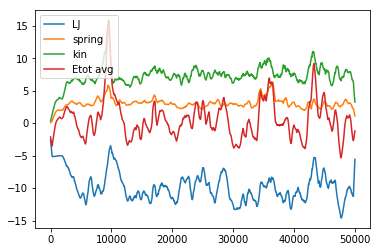

In [62]:
plt.plot(movingaverage(en[0], 500),label='LJ')
plt.plot(movingaverage(en[1], 500),label='spring')
plt.plot(movingaverage(en[2], 500),label='kin')
plt.plot(movingaverage(en[2]+en[1]+en[0], 500),label='Etot avg',)
plt.legend()

In [63]:
view_traj(pos,500)

NGLWidget(count=100)

In [68]:
pos,vel,en1 = MD_NVT_simulator(pos[-1],mass=mass,r_m=r_m,epsilon=epsilon,
                           k_spring=k_spring,temperature=T,
                           Nstep=100000,dt=dt,thermostat_Nstep=500)

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

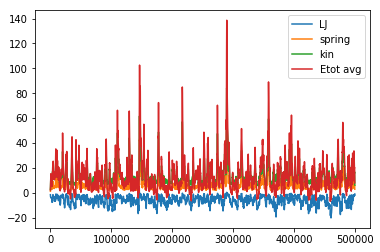

In [69]:
plt.plot(movingaverage(en1[0], 500),label='LJ')
plt.plot(movingaverage(en1[1], 500),label='spring')
plt.plot(movingaverage(en1[2], 500),label='kin')
plt.plot(movingaverage(en1[2]+en1[1]+en1[0], 500),label='Etot avg',)
plt.legend()

In [71]:
view_traj(pos,5000)

NGLWidget(count=100)